In [1]:
%matplotlib inline
import copy
import glob
import os
import random
import warnings
from argparse import ArgumentParser
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm_notebook as tqdm

warnings.filterwarnings('ignore')
from collections import Counter
from copy import copy
from pathlib import Path

import matplotlib.pyplot as plt
import neptune.new as neptune
import numpy as np
import pytorch_lightning as pl
# torch and lightning imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from neptune.new.types import File
from PIL import Image, ImageEnhance
from pytorch_lightning.callbacks.finetuning import BaseFinetuning
from pytorch_lightning.loggers import NeptuneLogger
from pytorch_lightning.utilities.rank_zero import rank_zero_info
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchmetrics import Accuracy, ConfusionMatrix
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import _log_api_usage_once


In [2]:
# Settings

# Function for setting the seed
seed = 42
pl.seed_everything(seed)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = (
    torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
)


Global seed set to 42


# General-purpose functions

In [3]:
def pad(spectrogram: np.ndarray, pad_length: int) -> np.ndarray:
    """
    Centre pads an RGB spectrogram to a given length.

    Args:
        spectrogram (np.ndarray): Spectrogram to pad.
        pad_length (int): Full length of padded spectrogram

    Returns:
        np.ndarray: Padded spectrogram
    """
    spec_shape = np.shape(spectrogram)
    excess_needed = pad_length - spec_shape[1]
    pad_left = int(np.floor(float(excess_needed) / 2))
    pad_right = int(np.ceil(float(excess_needed) / 2))
    padded_spec = np.full((spec_shape[0], pad_length, 3), np.min(spectrogram))
    padded_spec[:, pad_left : pad_length - pad_right, :] = spectrogram
    return padded_spec


# Data augmentation classes

## Custom transformations

In [4]:
class TimeCrop(torch.nn.Module):
    """
    Crops the given image at a random point in the time domain
    greater than its height and smaller than its maximum
    length minus its height.

    Note:
        Does not work with tensors.

    """

    def __init__(self):
        super().__init__()
        _log_api_usage_once(self)

    def forward(self, img):
        """
        Args:
            img (PIL Image): Image to be cropped.

        Returns:
            PIL Image: Cropped image.
        """
        img = np.asarray(img)
        H, W = img.shape[:2]
        if W < H:
            # Pads adding some extra width
            # so that the img is not always
            # in the same position
            img = pad(img, int(H + H * 0.25))

        H, W = img.shape[:2]
        r_idx = random.randint(0, W - H)
        img = img[:, r_idx : r_idx + H]
        return Image.fromarray(img)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"


class ChangeBrightness(torch.nn.Module):
    """
    Changes the brightness by a factor drawn from a uniform
    distribution between provided numbers.

    Args:
        factor (tuple): A tuple containing a range of
            brightness (e.g. 0.5 means 50% brightness).
        p (float): Probability with which the
            transformation will be applied.

    Warning:
        Does not work with tensors.

    """

    def __init__(self, factor: tuple = (0.9, 1.6), p: float = 0.5):
        super().__init__()
        _log_api_usage_once(self)
        self.factor = factor
        self.p = p

    def forward(self, img):
        """
        Args:
            img (PIL Image): Image to be modified.

        Returns:
            PIL Image: Modified image.
        """
        if self.p < torch.rand(1):
            return img
        f = random.uniform(self.factor[0], self.factor[1])
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(f)
        return img

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(factor={self.factor}, p={self.p})"


## Train/val/test transformations

In [5]:
class ImgTransform:
    def __init__(
        self,
        img_size=224,
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    ):
        self.stage = {
            "train": T.Compose(
                [
                    TimeCrop(),
                    T.RandomRotation(degrees=(-2, 2)),
                    T.RandomAdjustSharpness(sharpness_factor=6, p=0.2),
                    T.GaussianBlur(kernel_size=(3, 3), sigma=(0.005, 4)),
                    ChangeBrightness(factor=(0.8, 1.6), p=0.5),
                    T.ToTensor(),
                    # T.Normalize(mean, std),
                    T.RandomErasing(
                        p=0.2, scale=(0.02, 0.05), ratio=(0.3, 3.3)
                    ),
                ]
            ),
            "validate": T.Compose(
                [
                    TimeCrop(),
                    T.ToTensor(),
                    # T.Normalize(mean, std),
                ]
            ),
            "test": T.Compose(
                [
                    TimeCrop(),
                    T.ToTensor(),
                    # T.Normalize(mean, std),
                ]
            ),
        }


# Define data module

In [6]:
class GreatTitDataModule(pl.LightningDataModule):
    def __init__(self, train_path, test_path, batch_size=16, seed=42):
        super().__init__()
        self.batch_size = batch_size
        self.train_path = train_path
        self.test_path = test_path
        self.seed = seed

    def setup(self, stage=None):

        # Load and split training set
        d = ImageFolder(self.train_path)

        # Prepare weighted sampler for training data (oversample)
        class_count = Counter(d.targets)
        class_weights = torch.Tensor(
            [
                len(d.targets) / c
                for c in pd.Series(class_count).sort_index().values
            ]
        )

        sample_weights = [0] * len(d)
        for idx, (image, label) in enumerate(d):
            class_weight = class_weights[label]
            sample_weights[idx] = class_weight

        self.train_sampler = WeightedRandomSampler(
            weights=sample_weights, num_samples=len(d), replacement=True
        )

        # Stratified split for validation
        train_idx, valid_idx = train_test_split(
            np.arange(len(d.targets)),
            test_size=0.2,
            shuffle=True,
            random_state=self.seed,
            stratify=d.targets,
        )

        # Prepare train/validation/test datasets
        self.train, self.validate = copy(d), copy(d)
        self.train.imgs = np.array(d.imgs)[train_idx].tolist()
        self.train.targets = np.array(d.targets)[train_idx].tolist()
        self.validate.imgs = np.array(d.imgs)[valid_idx].tolist()
        self.validate.targets = np.array(d.targets)[valid_idx].tolist()
        self.test = ImageFolder(self.test_path)

        # Transforms
        self.train.transform = ImgTransform().stage["train"]
        self.validate.transform = ImgTransform().stage["validate"]
        self.test.transform = ImgTransform().stage["test"]

    def train_dataloader(self):
        return DataLoader(
            self.train,
            batch_size=self.batch_size,
            num_workers=8,
            pin_memory=True,
            sampler=self.train_sampler,
        )

    def val_dataloader(self):
        return DataLoader(
            self.validate,
            batch_size=100,
            shuffle=True,
            num_workers=8,
            pin_memory=True,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test,
            batch_size=100,
            shuffle=True,
            num_workers=8,
            pin_memory=True,
        )

    # def predict_dataloader(self):
    #     return DataLoader(
    #         self.test,
    #         batch_size=100,
    #         shuffle=True,
    #         num_workers=8,
    #         pin_memory=True,
    #     )


# Fine tuning module

In [7]:
# -------------
# See:
# https://github.com/PyTorchLightning/pytorch-lightning/blob/master/pl_examples/domain_templates/computer_vision_fine_tuning.py
class MilestonesFinetuning(BaseFinetuning):
    def __init__(self, milestones: tuple = (5, 10), train_bn: bool = False):
        super().__init__()
        self.milestones = milestones
        self.train_bn = train_bn

    def freeze_before_training(self, pl_module: pl.LightningModule):
        self.freeze(modules=pl_module.feature_extractor, train_bn=self.train_bn)

    def finetune_function(
        self,
        pl_module: pl.LightningModule,
        epoch: int,
        optimizer: Optimizer,
        opt_idx: int,
    ):
        if epoch == self.milestones[0]:
            # unfreeze 5 last layers
            self.unfreeze_and_add_param_group(
                modules=pl_module.feature_extractor[-5:],
                optimizer=optimizer,
                train_bn=self.train_bn,
            )

        elif epoch == self.milestones[1]:
            # unfreeze remaining layers
            self.unfreeze_and_add_param_group(
                modules=pl_module.feature_extractor[:-5],
                optimizer=optimizer,
                train_bn=self.train_bn,
            )


# Main model module

In [8]:
logg_params = {
    "on_step": True,
    "on_epoch": True,
    "prog_bar": True,
    "logger": True,
}


class ResNetClassifier(pl.LightningModule):
    def __init__(
        self,
        num_classes: int = None,
        backbone: str = "resnet50",
        train_bn: bool = False,
        batch_size: int = 16,
        transfer=True,
        milestones: tuple = (2, 4),
        lr: float = 1e-3,
        lr_scheduler_gamma: float = 1e-1,
    ):
        super().__init__()

        self.__dict__.update(locals())
        self.num_classes = num_classes
        self.backbone = backbone
        self.transfer = transfer = (True,)
        self.lr = lr
        self.milestones = milestones
        self.lr_scheduler_gamma = lr_scheduler_gamma
        self.batch_size = batch_size

        self.__build_model()

        self.train_acc = Accuracy()
        self.valid_acc = Accuracy()
        self.test_acc = Accuracy()
        self.save_hyperparameters()

        self.val_confusion = ConfusionMatrix(num_classes=self.num_classes)
        self.test_confusion = ConfusionMatrix(num_classes=self.num_classes)

    def __build_model(self):
        """Define model layers & loss."""

        # 1. Load pre-trained network:
        model_func = getattr(models, self.backbone)
        self.backbone = model_func(pretrained=self.transfer)

        _layers = list(self.backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*_layers)
        linear_size = list(self.backbone.children())[-1].in_features

        # 2. Classifier:
        # _fc_layers = [nn.Linear(2048, 1000), nn.ReLU(), nn.Linear(1000, self.num_classes)]
        # self.backbone.fc = nn.Sequential(*_fc_layers)
        self.backbone.fc = nn.Linear(linear_size, self.num_classes)

        # 3. Loss:
        self.loss_func = (
            nn.BCEWithLogitsLoss()
            if self.num_classes == 2
            else nn.CrossEntropyLoss()
        )

    def forward(self, x):
        return self.backbone(x)

    def configure_optimizers(self):
        parameters = list(self.parameters())
        trainab_params = list(filter(lambda p: p.requires_grad, parameters))
        rank_zero_info(
            f"The model will start training with only {len(trainab_params)} "
            f"trainable parameters out of {len(parameters)}."
        )
        optimizer = optim.Adam(trainab_params, lr=self.lr)
        scheduler = MultiStepLR(
            optimizer, milestones=self.milestones, gamma=self.lr_scheduler_gamma
        )
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)

        loss = self.loss_func(preds, y)
        self.train_acc(preds, y)
        self.log("train/loss", loss, **logg_params)
        self.log("train/acc", self.train_acc, **logg_params)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)

        loss = self.loss_func(preds, y)
        self.train_acc(preds, y)
        self.log("val/loss", loss, **logg_params)
        self.log("val/acc", self.train_acc, **logg_params)
        self.val_confusion.update(preds, batch[1])

    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)

        loss = self.loss_func(preds, y)
        self.test_acc(preds, y)
        self.log("test/loss", loss, **logg_params)
        self.log("test/acc", self.test_acc, **logg_params)
        self.test_confusion.update(preds, batch[1])

        # Save wrong prediction images
        y_true = y.cpu().detach().numpy()
        y_pred = preds.argmax(axis=1).cpu().detach().numpy()

        for j in np.where(np.not_equal(y_true, y_pred))[0]:
            img = np.squeeze(x[j].cpu().detach().numpy())
            img[img < 0] = 0
            img = img / np.amax(img)
            labs = list(
                self.trainer.datamodule.val_dataloader().dataset.class_to_idx.keys()
            )
            neptune_logger.experiment["test/misclassified_images"].log(
                neptune.types.File.as_image(img.transpose((1, 2, 0))),
                description=f"y_pred = {labs[y_pred[j]]}, y_true = {labs[y_true[j]]}",
            )

    # Output graphs and extra metrics
#     def plot_conf_matrix(self, conf_mat):
#         labs = (
#             self.trainer.datamodule.val_dataloader().dataset.class_to_idx.keys()
#         )
#         df_cm = pd.DataFrame(conf_mat, index=labs, columns=labs)
#         plt.figure(figsize=(13, 10))
#         fig_ = sns.heatmap(
#             df_cm, annot=True, cmap="magma", fmt="g"
#         ).get_figure()
#         plt.close(fig_)
#         return fig_

#     def validation_epoch_end(self, outputs):
#         conf_mat = (
#             self.val_confusion.compute().detach().cpu().numpy().astype(np.int)
#         )
#         fig_ = self.plot_conf_matrix(conf_mat)
#         self.logger.experiment["train/confusion_matrix"].log(
#             File.as_image(fig_)
#         )

#     def test_epoch_end(self, outputs):
#         conf_mat = (
#             self.test_confusion.compute().detach().cpu().numpy().astype(np.int)
#         )
#         fig_ = self.plot_conf_matrix(conf_mat)
#         self.logger.experiment["test/confusion_matrix"].log(File.as_image(fig_))


# Prepare dataset

In [9]:
import git

PROJECT_ROOT = Path(
    git.Repo(".", search_parent_directories=True).working_tree_dir
)
DATASET =  "GRETI_2021-22"

data_path = PROJECT_ROOT / "data" / "datasets" / DATASET / "ML"
train_path = data_path / "train"
test_path = data_path / "test"


n_classes = sum([1 for i in test_path.glob("**/")]) - 1


class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


hparams = AttrDict(
    {
        "batch_size": 64,
        "num_classes": n_classes,
        "lr": 0.001,
        "lr_scheduler_gamma": 0.1,
        "milestones": (10, 15),
        "transfer": True,
        "train_bn": False,
    }
)

dm = GreatTitDataModule(
    train_path=train_path,
    test_path=test_path,
    batch_size=hparams.batch_size,
)

dm.setup()


# Training

## Start logger and checkpoints

In [10]:
# !pip install neptune-client


def _init_neptune():
    run = neptune.init(
        project="nilomr/greti",
        api_token=(
            "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdX"
            "JsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2NT"
            "ExYjE1My1lMWU2LTQwNjctYTA4OC03YjZkZDIxMWE2N2YifQ=="
        ),
        flush_period=5,
        run="GRET-70",  # NOTE: Remove if new run!!
        mode="sync",  # async won't work in Oxford HPC
    )
    return run


def init_neptune_logger():
    try:
        return _init_neptune()
    except:
        try:
            return _init_neptune()
        except Exception as e:
            raise e


neptune_logger = NeptuneLogger(run=init_neptune_logger())  #

CHECKPOINTS_DIR = "checkpoints"
model_checkpoint = pl.callbacks.ModelCheckpoint(
    dirpath=CHECKPOINTS_DIR,
    monitor="val/acc_epoch",
    mode="max",
    save_top_k=2,
    save_weights_only=True,
)


https://app.neptune.ai/nilomr/greti/e/GRET-70
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


## Instantiate model and trainer

In [11]:
model = ResNetClassifier(**hparams)

trainer = pl.Trainer(
    max_epochs=30,
    logger=neptune_logger,
    checkpoint_callback=model_checkpoint,
    callbacks=[
        EarlyStopping(monitor="val/loss_epoch", mode="min", patience=4),
        MilestonesFinetuning(milestones=(5, 10), train_bn=hparams.train_bn),
    ],
    log_every_n_steps=1,
    accelerator="gpu",
    devices=1,
    precision=16,
    num_sanity_val_steps=0,  # Validation gets stuck with full dataset: BUG
)


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Train model

In [44]:
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
The model will start training with only 2 trainable parameters out of 161.

  | Name              | Type             | Params
-------------------------------------------------------
0 | backbone          | ResNet           | 25.1 M
1 | feature_extractor | Sequential       | 23.5 M
2 | loss_func         | CrossEntropyLoss | 0     
3 | train_acc         | Accuracy         | 0     
4 | valid_acc         | Accuracy         | 0     
5 | test_acc          | Accuracy         | 0     
6 | val_confusion     | ConfusionMatrix  | 0     
7 | test_confusion    | ConfusionMatrix  | 0     
-------------------------------------------------------
1.6 M     Trainable params
23.5 M    Non-trainable params
25.1 M    Total params
50.155    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Test best model in held out (test) dataset

## Retrieve model

In [13]:
# best_model = ResNetClassifier.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
# If from fresh session:

lckpt = list(
    (
        Path(neptune_logger.save_dir)
        / "Untitled"
        / neptune_logger._run_short_id
        / "checkpoints"
    ).glob("*ckpt")
)[-1]
best_model = ResNetClassifier.load_from_checkpoint(lckpt)

## Get model predictions for test set

In [19]:
trainer.test(best_model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test/acc_epoch         0.9495213031768799
     test/loss_epoch        0.21302251517772675
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/loss_epoch': 0.21302251517772675,
  'test/acc_epoch': 0.9495213031768799}]

# Use model to extract feature vectors from the entire dataset

In [42]:
imgpaths = [i for i in train_path.glob("*/*.jpg")]
test_imgs = [i for i in test_path.glob("*/*.jpg")]
best_model.eval()
best_model.to(device)
vectors = {}

# Test transformation includes random crop in the time domain:
# Run multiple times and average to increase robustness:
niters = 5

for i in range(niters):
    vectors[str(i)] = {}
    for path in tqdm(imgpaths, total=len(imgpaths)):
        img = Image.open(path)
        rgb_img = TimeCrop()(img)
        tens_img = T.ToTensor()(rgb_img).unsqueeze_(0)
        vectors[str(i)][f"{path.stem}"] = (
            best_model.feature_extractor(tens_img.to(device))
            .cpu()
            .detach()
            .numpy()[0, :, 0, 0]
        )

In [ ]:
## Export feature vectors

In [54]:
alldfs = pd.concat([pd.DataFrame.from_dict(d, orient='index') for d in vectors.values()])
vocmean = alldfs.groupby(alldfs.index).mean()

vector_dir = PROJECT_ROOT / "data" / "datasets" / DATASET / 'ML' / 'output' / 'feat_vectors.csv'
vector_dir.parent.mkdir(parents=True, exist_ok=True)
vocmean.to_csv(vector_dir)

## Predict classes

In [14]:
import torch.nn.functional as F

best_model.eval()
# Predict labels for image
predimg = list(test_path.glob("*/*"))[0]

img = Image.open(predimg)
x = T.ToTensor()(img).unsqueeze_(0)
y_hat = best_model(x)

# One way
prob = F.softmax(y_hat, dim=1)
pred = torch.max(prob, 1)

classes = list(dm.train.class_to_idx.keys())
pred_class = classes[int(pred[1][0])]
print(f"true: {predimg.parent.name}, predicted: {pred_class}")


true: 20201B165_2, predicted: 20201B165_2


# Explore transformations

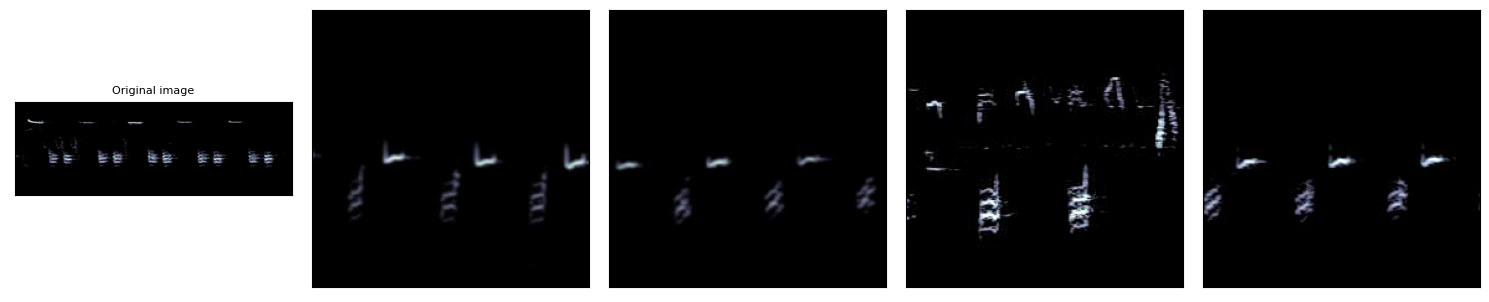

In [ ]:
def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(
        nrows=num_rows, ncols=num_cols, squeeze=False, figsize=(15, 8), dpi=100
    )
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title="Original image")
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()


plt.rcParams["savefig.bbox"] = "tight"
orig_img = Image.open(train_path / "B227_4/B227_20210418_040000_71.jpg")

trainer.datamodule.val_dataloader()


imgs = [Image.open(img) for img in list(train_path.rglob("*.jpg"))[:4]]
test_img = [ImgTransform().stage["train"](img).permute(1, 2, 0) for img in imgs]

plot(test_img[:20])


TypeError: only integer tensors of a single element can be converted to an index

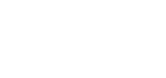

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dm.val_dataloader()):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f"predicted: {dm.train.targets[preds[j]]}")
                plt.imshow(inputs.cpu().data[j].permute(1, 2, 0))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


visualize_model(best_model.to(device))


# Model interpretation

In [ ]:
# https://medium.com/intelligentmachines/implementation-of-class-activation-map-cam-with-pytorch-c32f7e414923


In [ ]:
#!pip install grad-cam


     |████████████████▉               | 8.8 MB 11.5 MB/s eta 0:00:01Warning: string series 'monitoring/stdout' value was longer than 1000 characters and was truncated. This warning is printed only once per series.
     |████████████████████████████████| 16.8 MB 11.5 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 60.5 MB 79 kB/s /s eta 0:00:01��                          | 11.5 MB 123.8 MB/s eta 0:00:01��███▉                      | 18.7 MB 123.8 MB/s eta 0:00:01
  Created wheel for grad-cam: filename=grad_cam-1.3.9-py3-none-any.whl size=25964 sha256=3c18df6785223cc94b7a30ebd7980dcf3af0132c7718ebfb2a128a268c96a923
  Stored in directory: /home/shil5293/.cache/pip/wheels/33/c6/88/fdce599db7a1b46be5795c955bb1eaa0128d86bf68f0868abb
Successfully built grad-cam


In [ ]:
from pytorch_grad_cam import (
    GradCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    EigenCAM,
    FullGrad,
)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50


In [29]:
imgpaths = [i for i in train_path.glob("*/*.jpg")]


In [ ]:
random.seed(42)
img_paths = random.sample(imgpaths, 50)
out_folder = PROJECT_ROOT / "reports" / "figures" / "activation_maps"
out_folder.mkdir(parents=True, exist_ok=True)

for path in img_paths:
    img = Image.open(path)
    rgb_img = TimeCrop()(img)
    tens_img = T.ToTensor()(rgb_img).unsqueeze_(0)

    # img = Image.open(train_path / "O30_3/O30_20210417_040000_32.jpg")
    # input_tensor = T.ToTensor()(img).unsqueeze_(0)

    model = resnet50(pretrained=True)
    target_layers = [model.layer4[-1]]

    # target_layers = [list(best_model.backbone.children())[-1]]
    # target_layers = [list(best_model.backbone.children())[7][-1]]
    with GradCAM(
        model=model, target_layers=target_layers, use_cuda=True
    ) as cam:
        grayscale_cam = cam(
            input_tensor=tens_img, targets=None, eigen_smooth=True
        )

    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(
        np.float32(rgb_img) / 255, grayscale_cam, use_rgb=True
    )
    img = Image.fromarray(visualization)
    img.save(out_folder / f"{path.stem}.jpg")


In [32]:
k = len(range(7, 11))

similarNames = pd.DataFrame(index=similarityMatrix.index, columns=range(k))
similarValues = pd.DataFrame(index=similarityMatrix.index, columns=range(k))
for j in tqdm(range(similarityMatrix.shape[0])):
    kSimilar = similarityMatrix.iloc[j, :].sort_values(ascending=False)[7:11]
    similarNames.iloc[j, :] = list(kSimilar.index)
    similarValues.iloc[j, :] = kSimilar.values


  0%|          | 0/3353 [00:00<?, ?it/s]

In [33]:
import matplotlib.pyplot as plt


def getSimilarImages(image, simNames, simVals):
    if image in set(simNames.index):
        imgs = list(simNames.loc[image, :])
        vals = list(simVals.loc[image, :])
        if image in imgs:
            assert_almost_equal(max(vals), 1, decimal=5)
            imgs.remove(image)
            vals.remove(max(vals))
        return imgs, vals
    else:
        print("'{}' Unknown image".format(image))


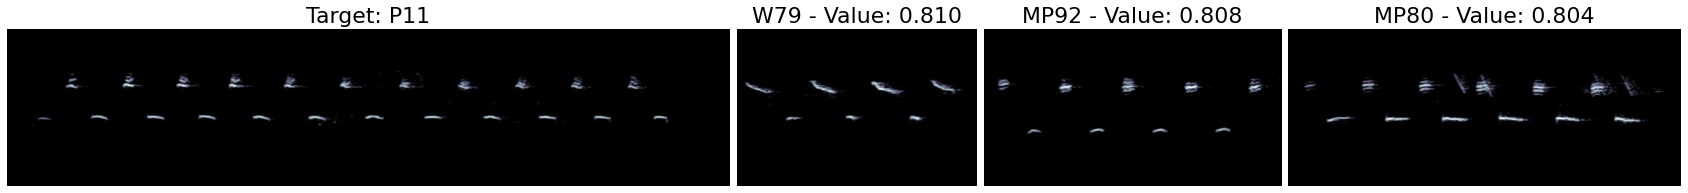

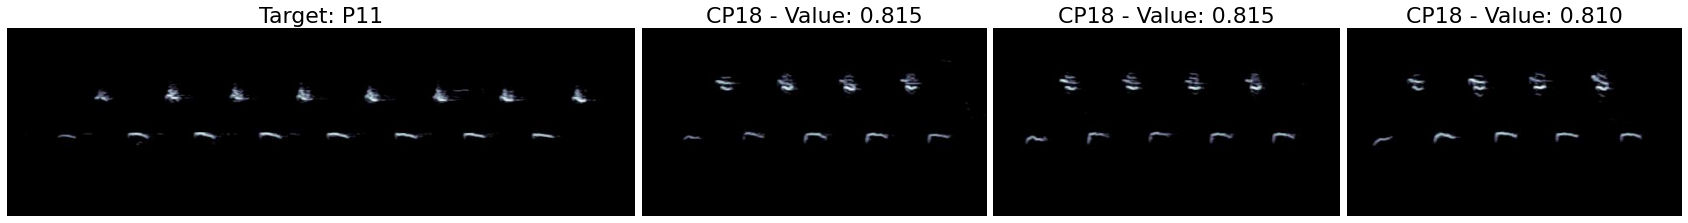

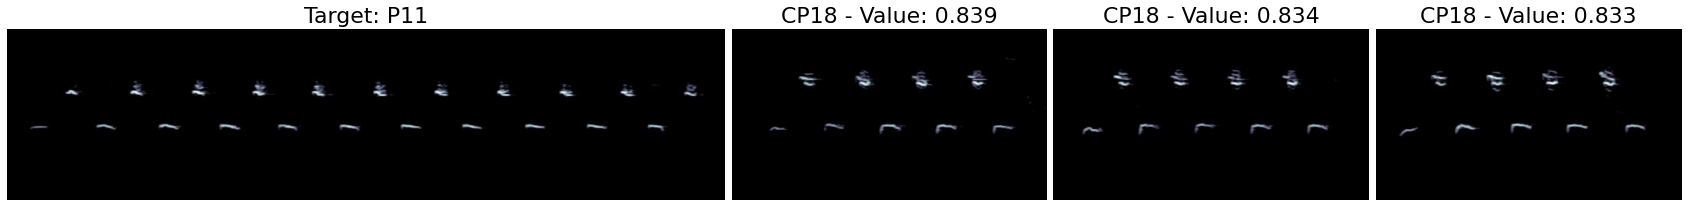

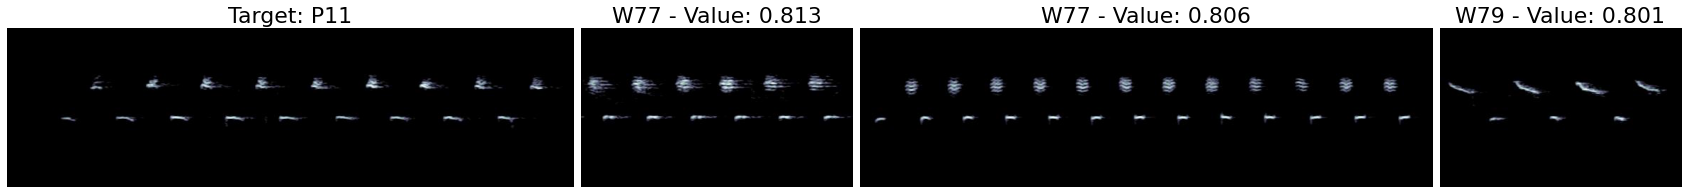

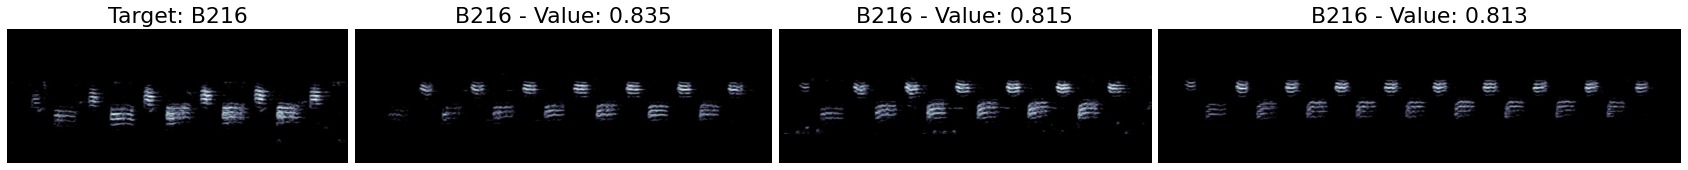

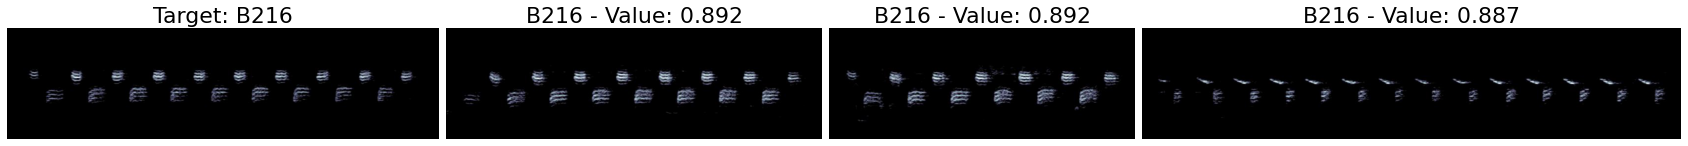

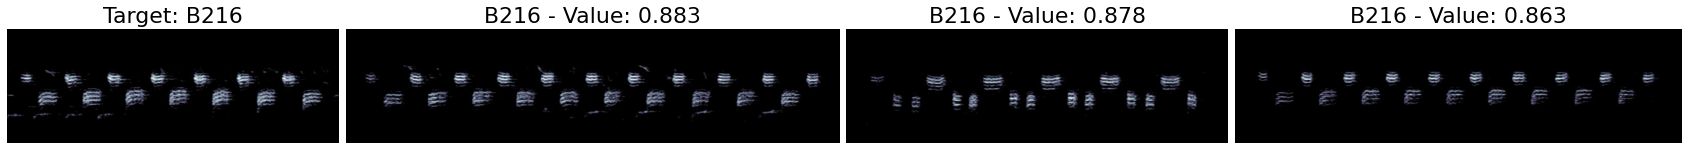

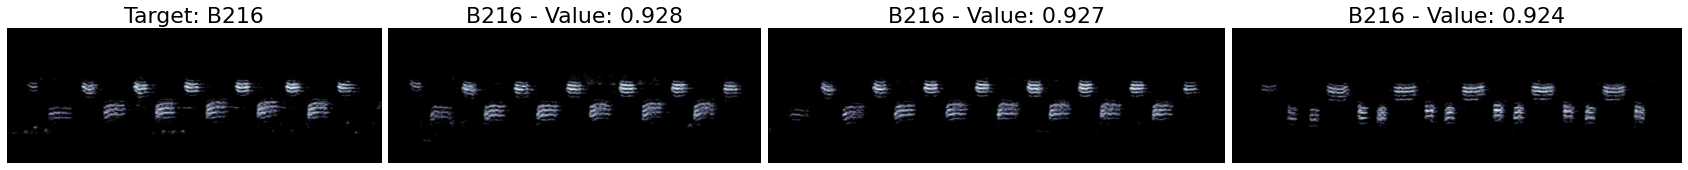

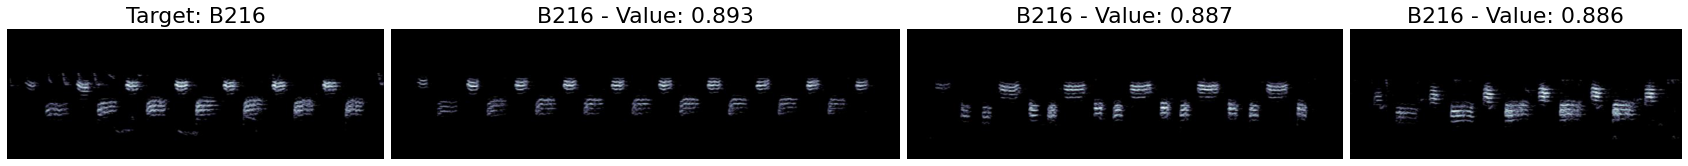

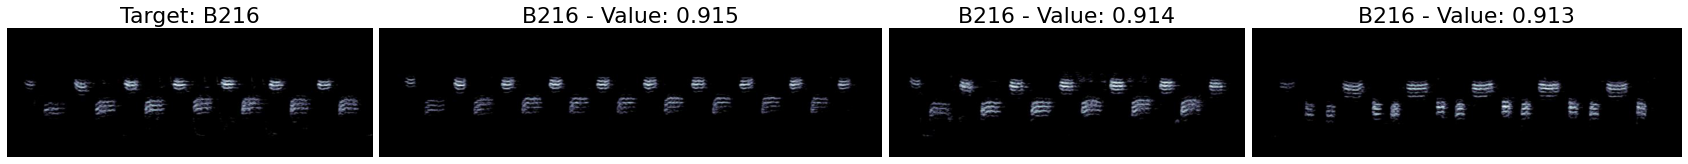

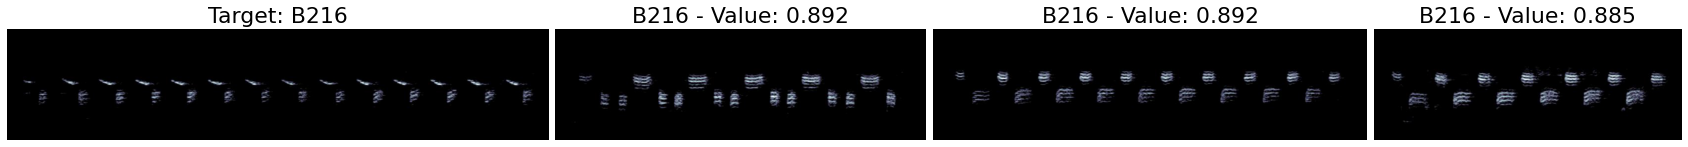

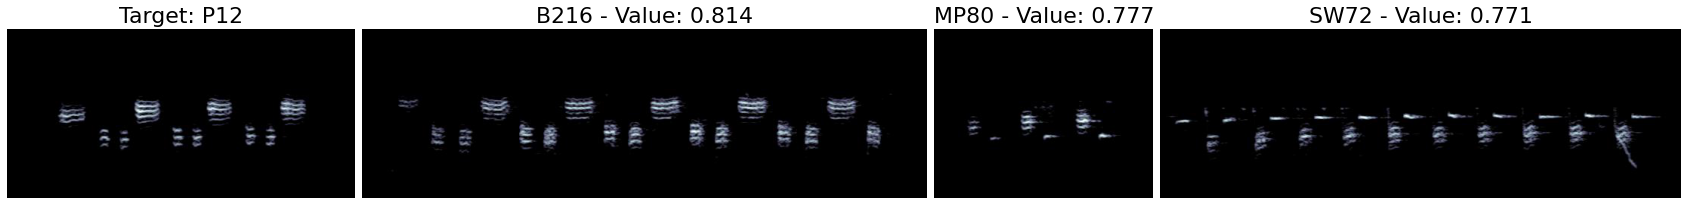

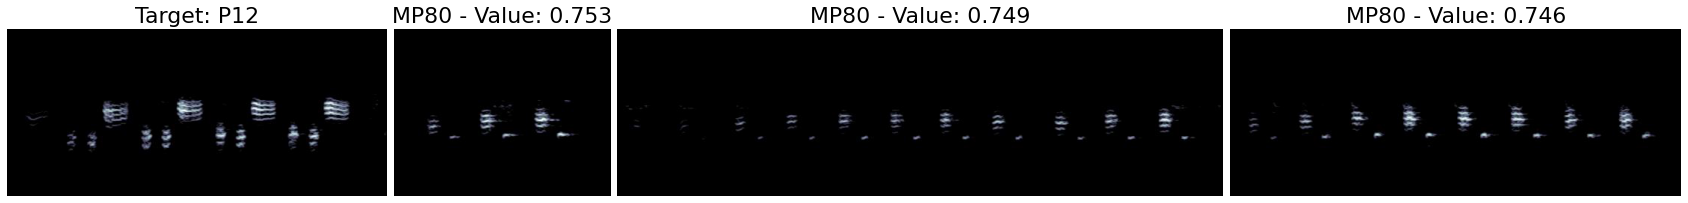

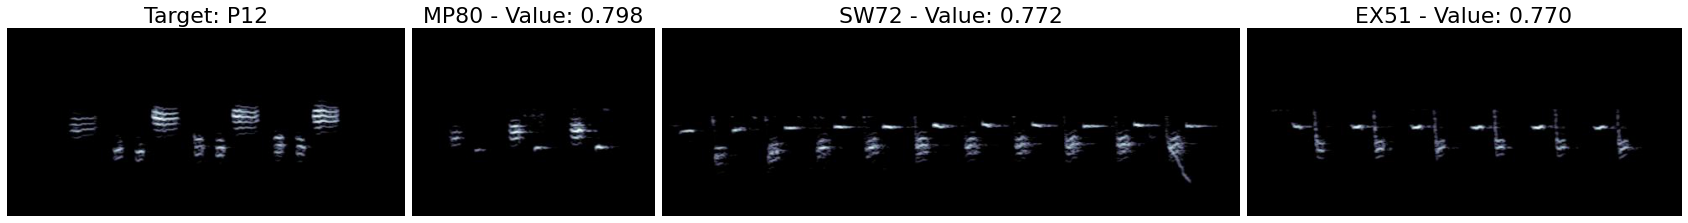

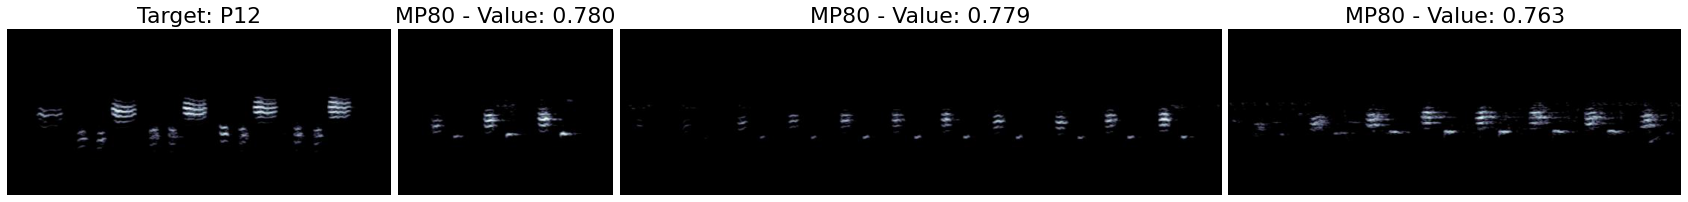

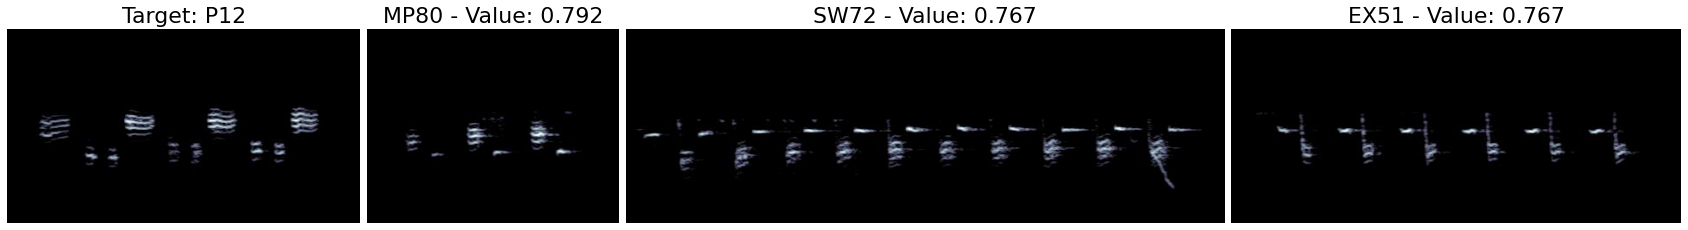

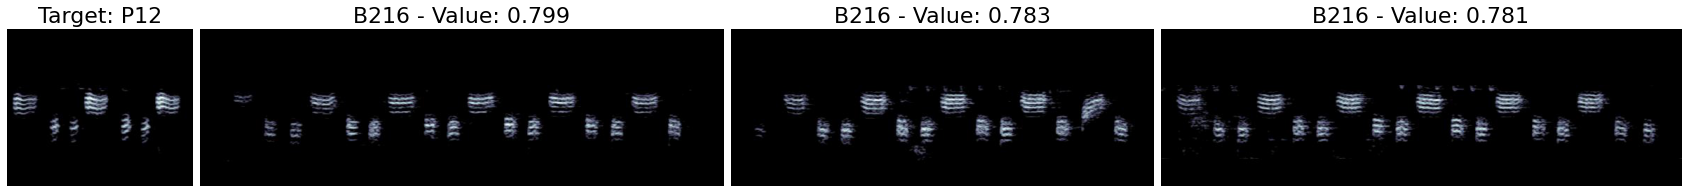

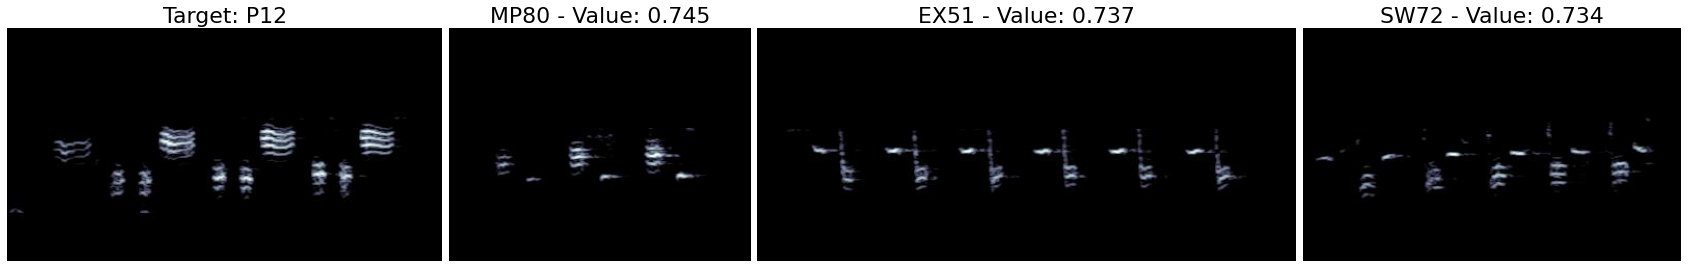

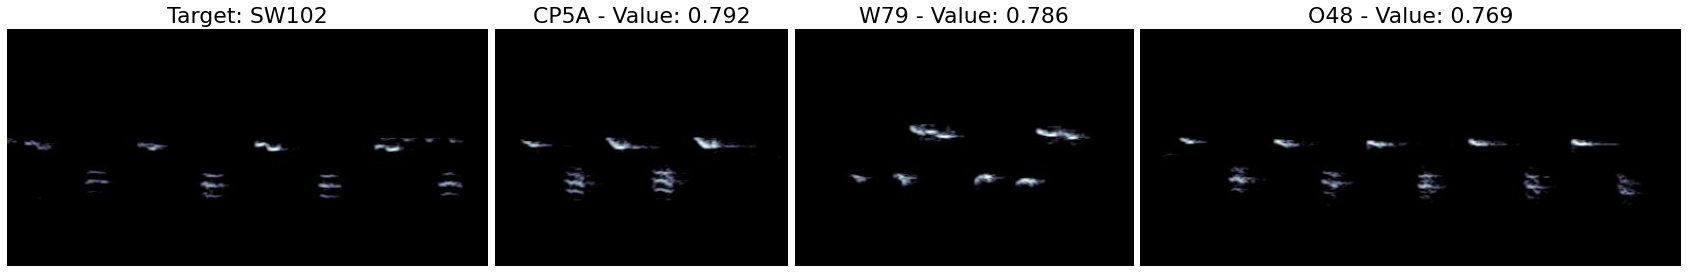

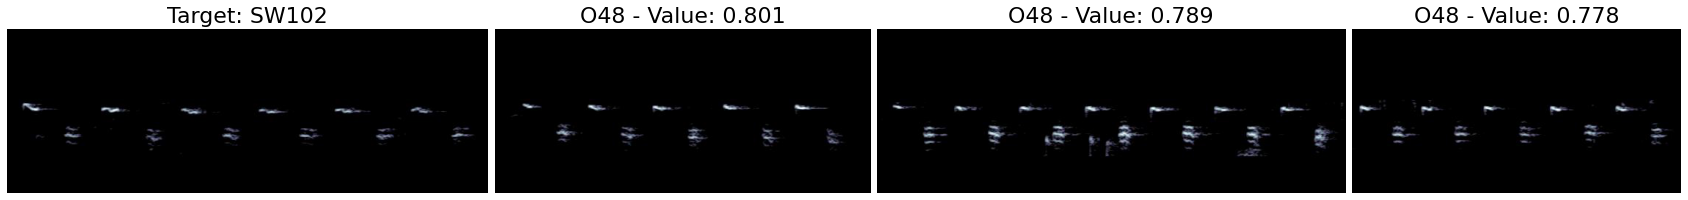

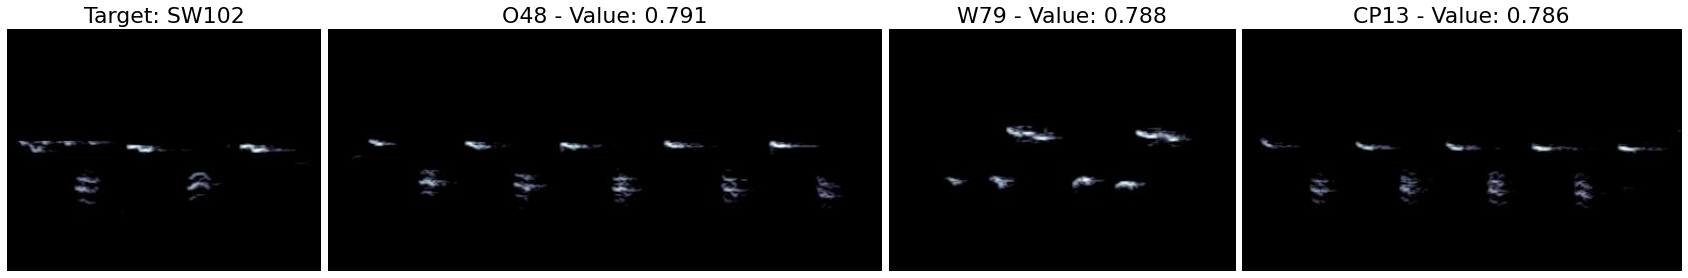

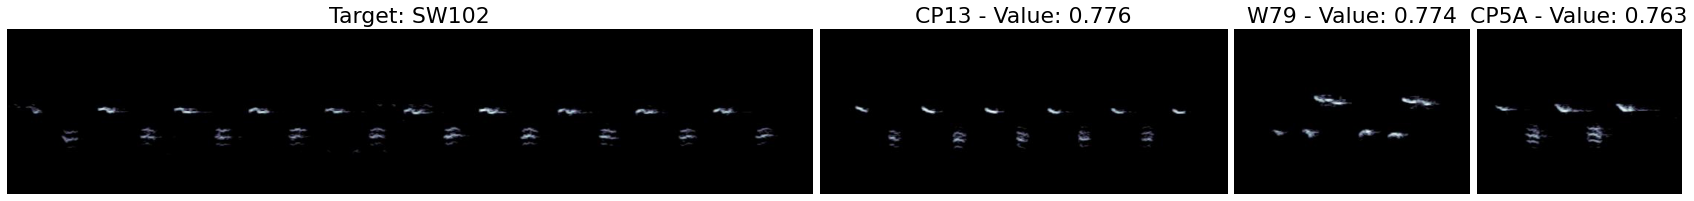

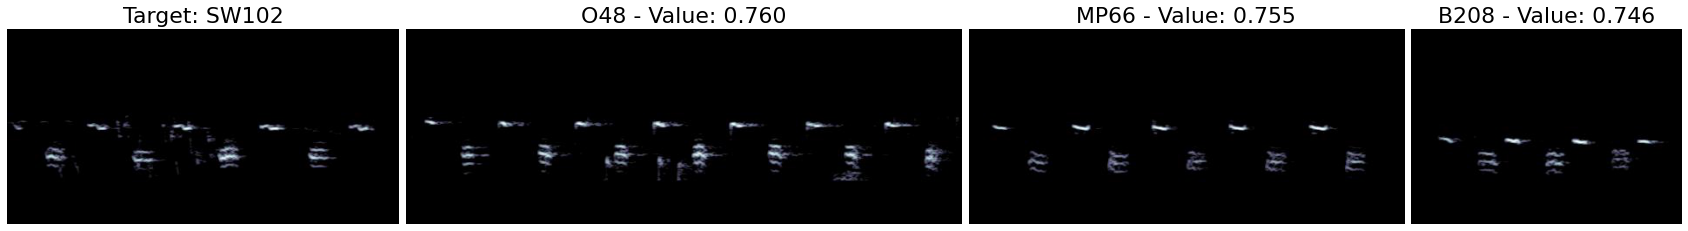

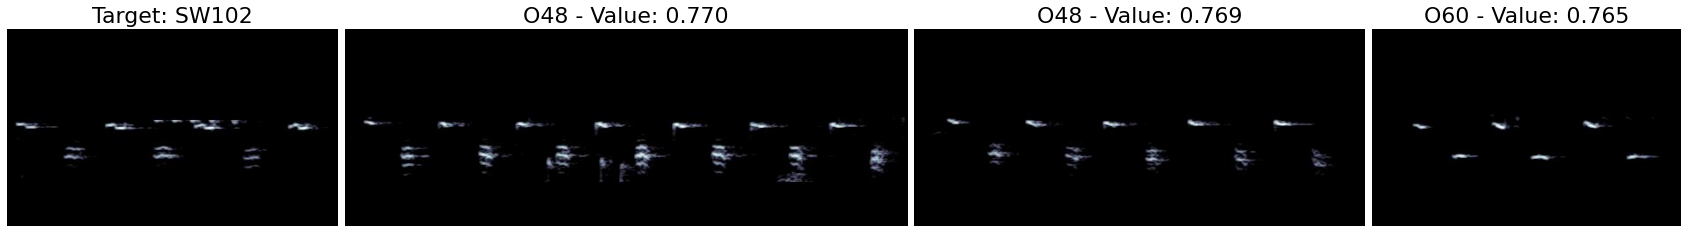

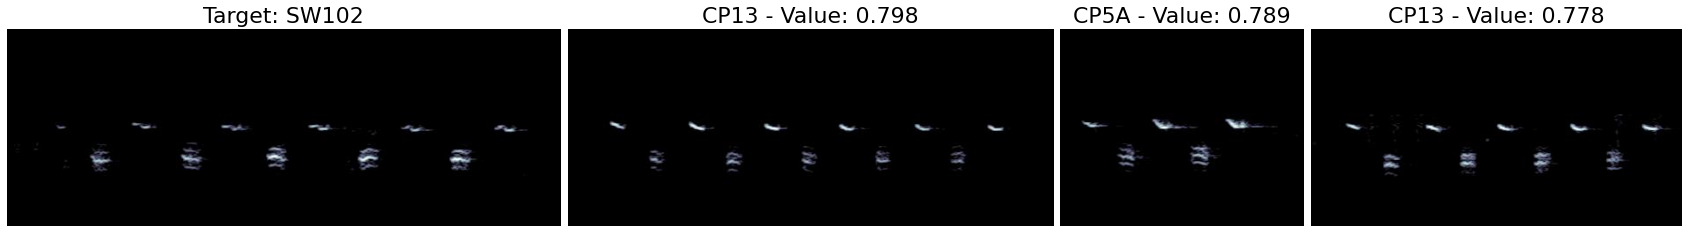

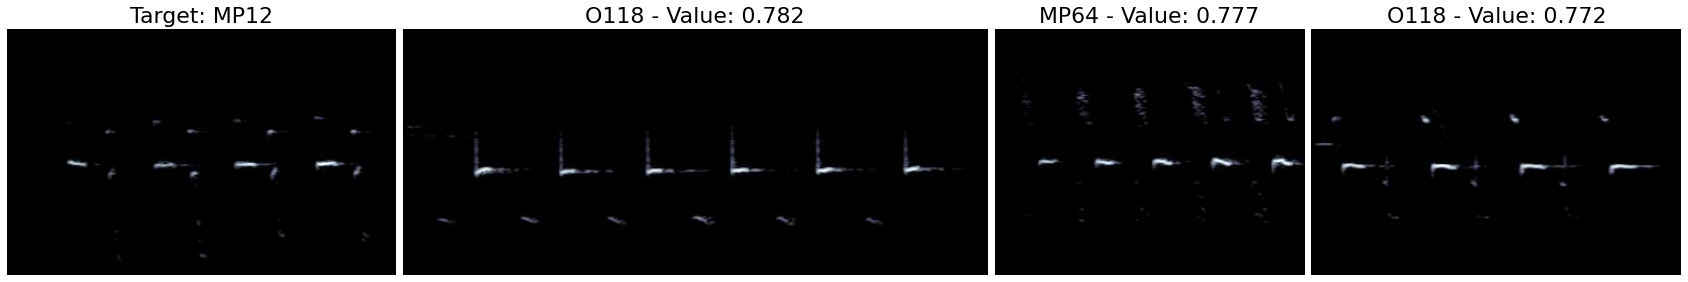

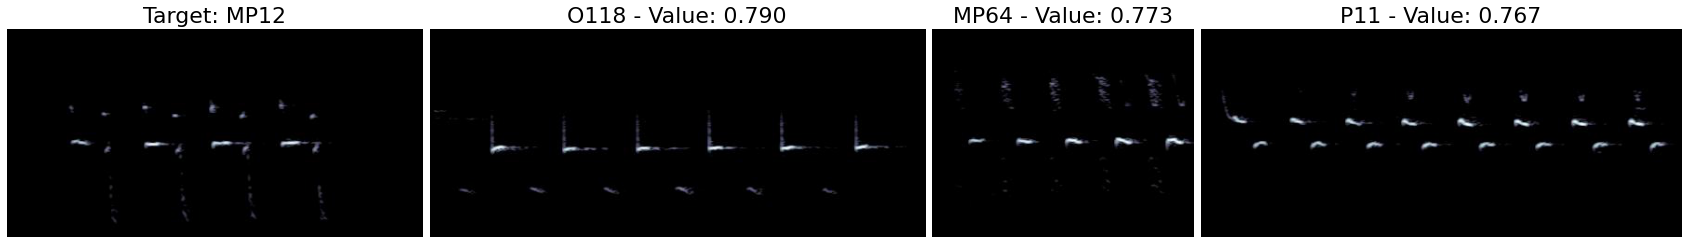

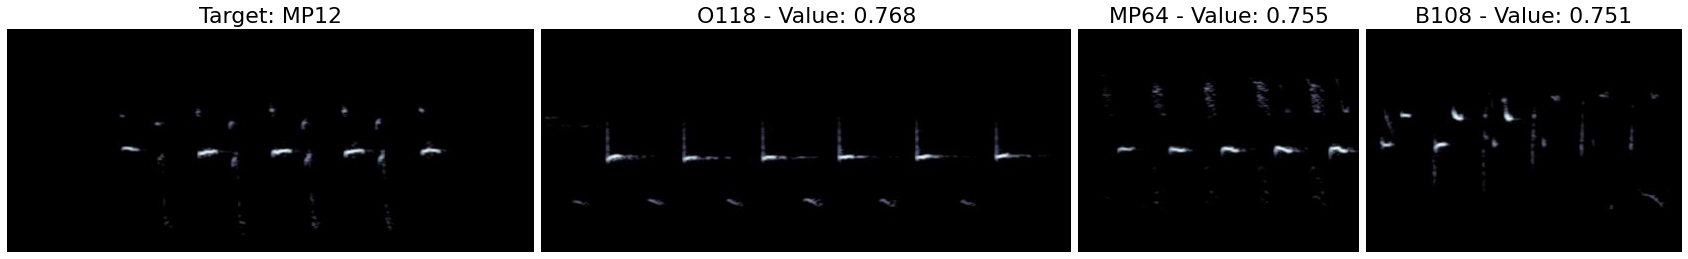

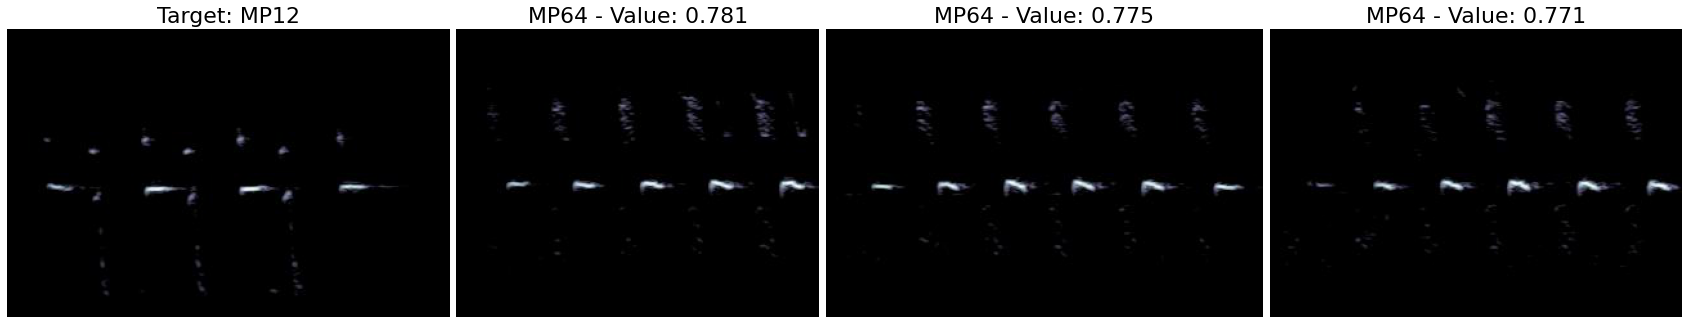

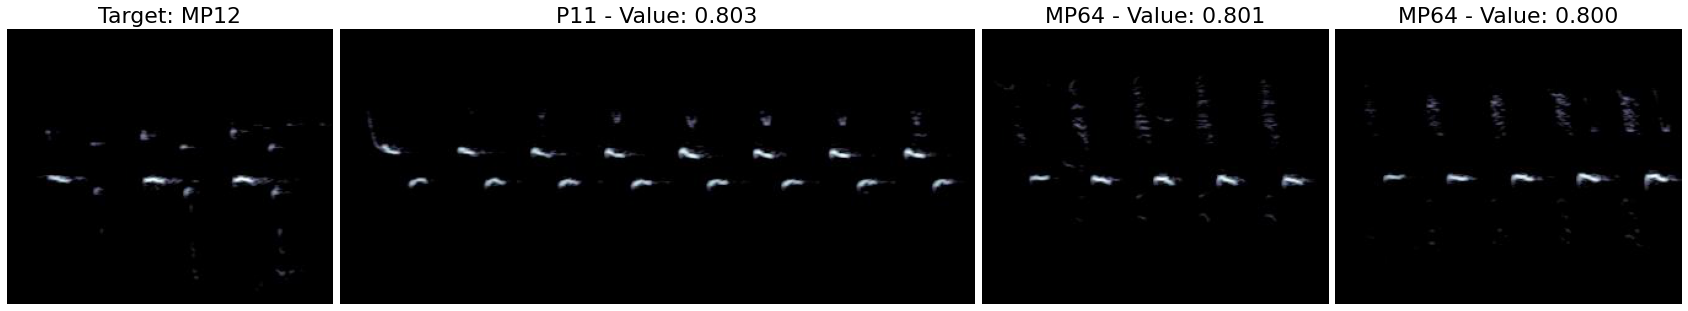

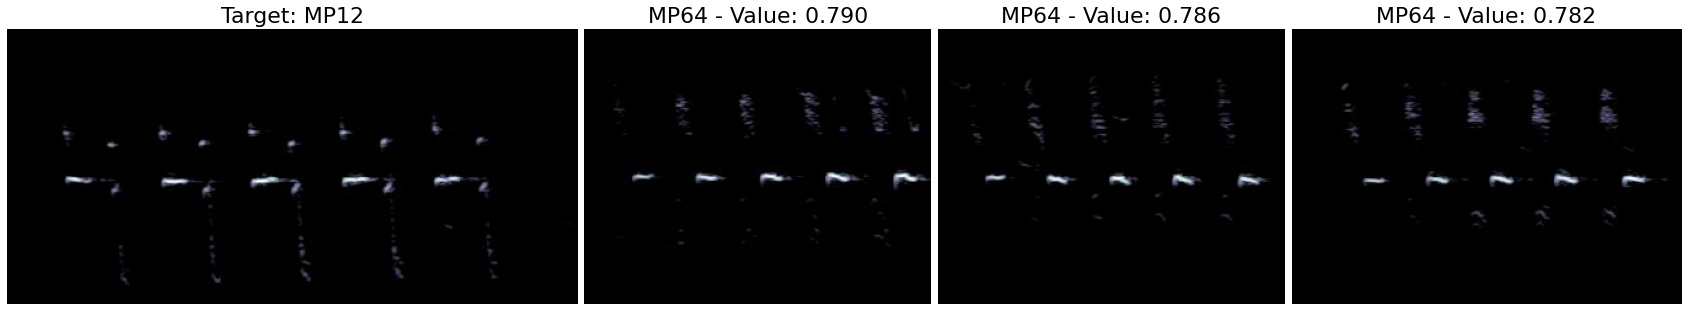

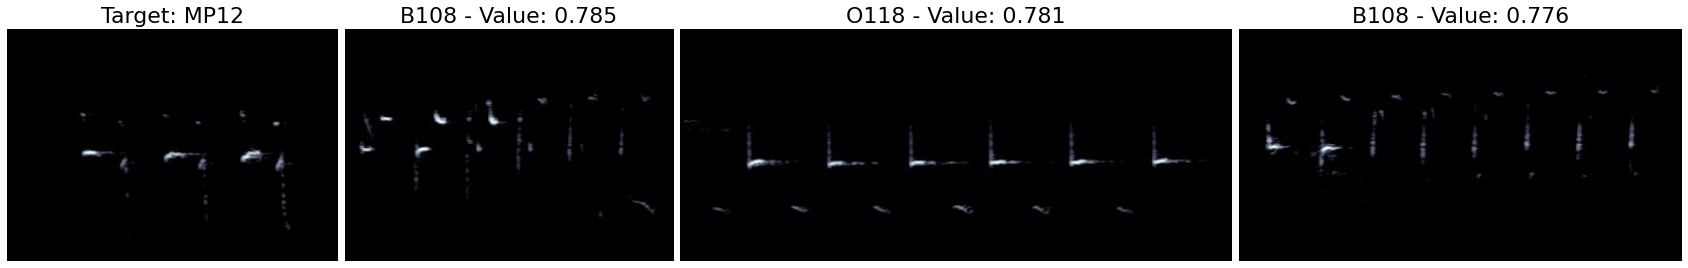

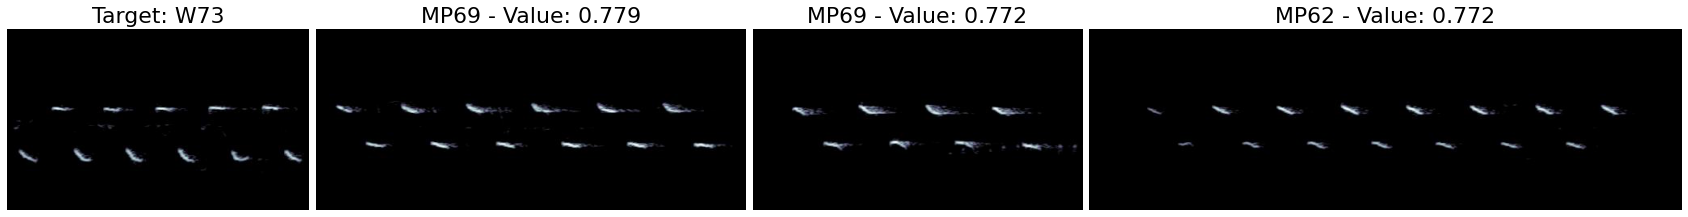

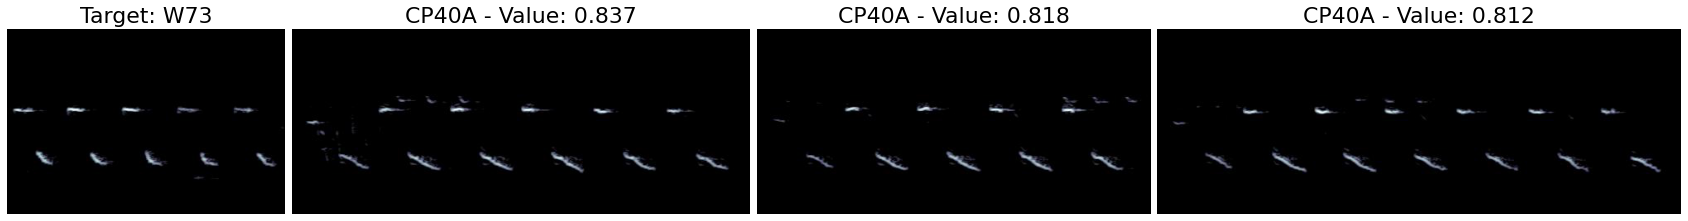

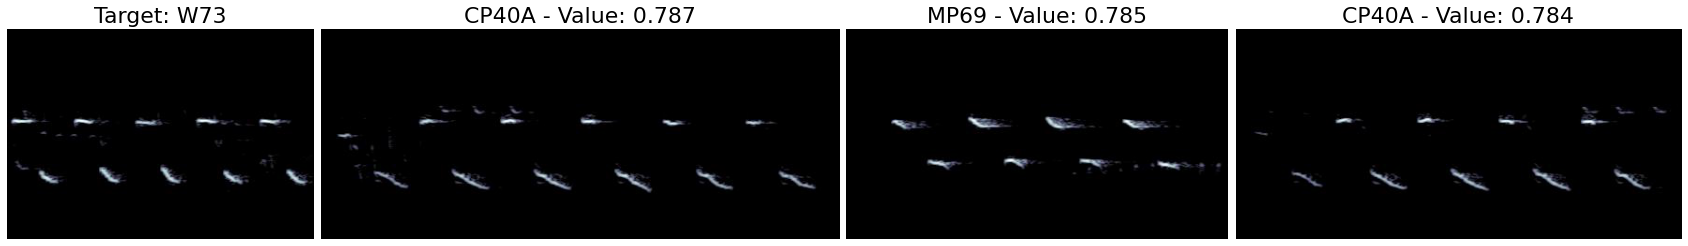

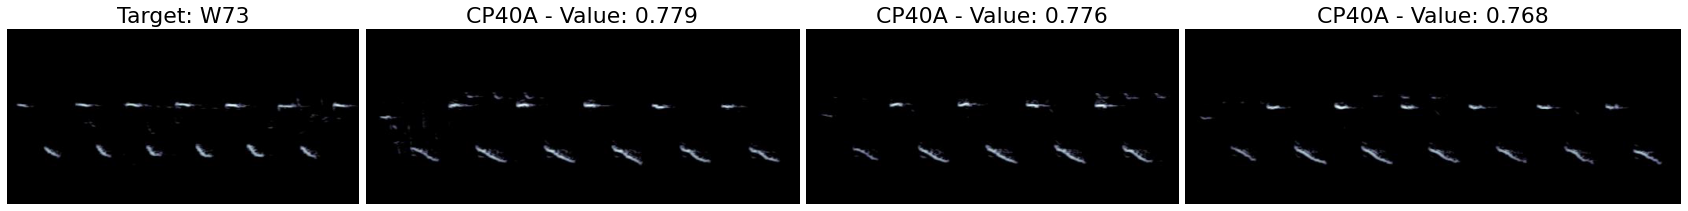

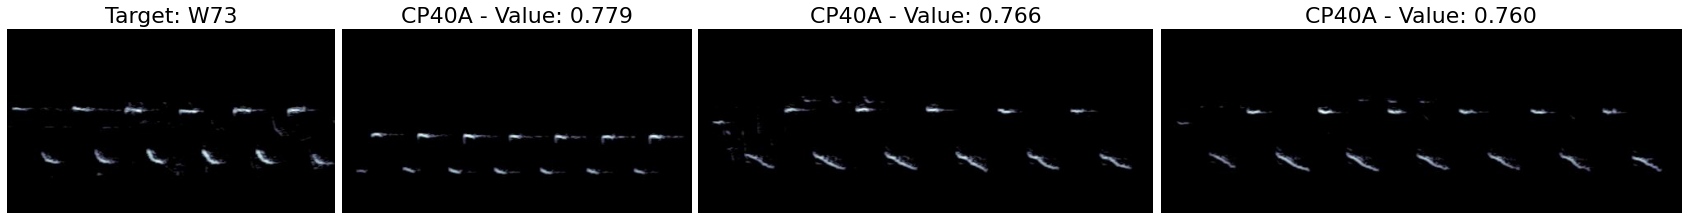

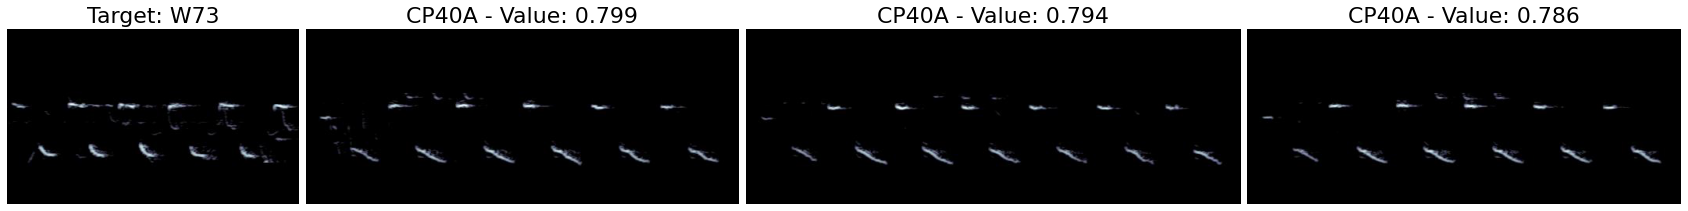

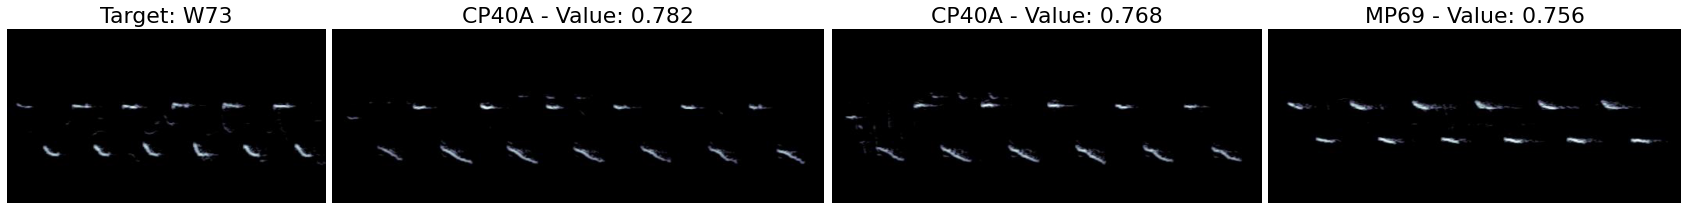

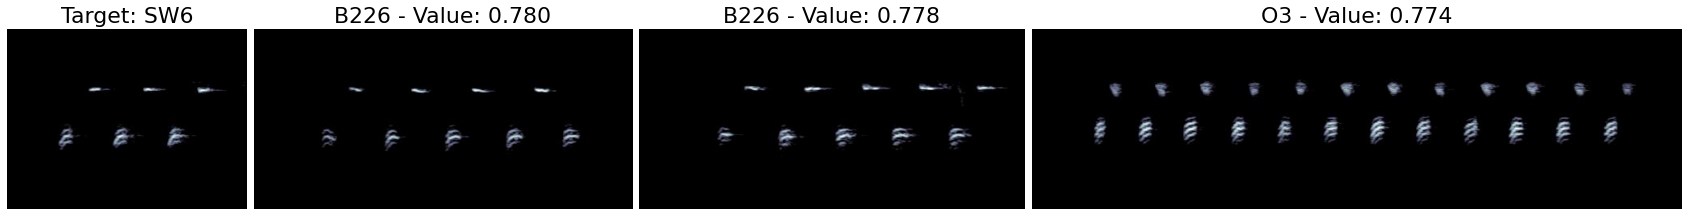

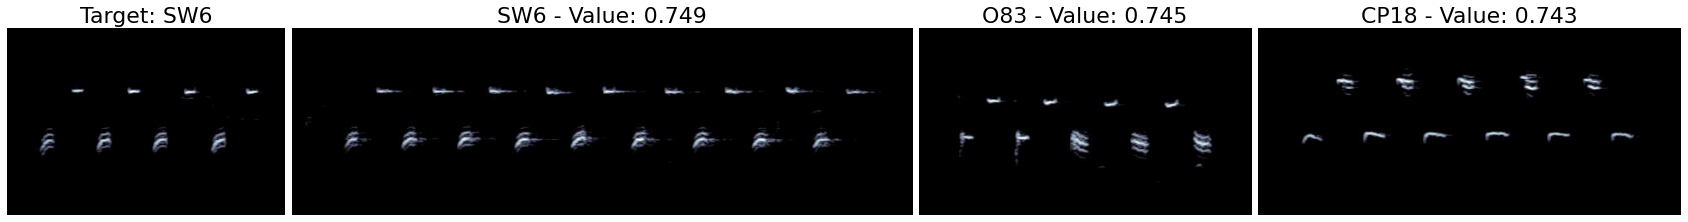

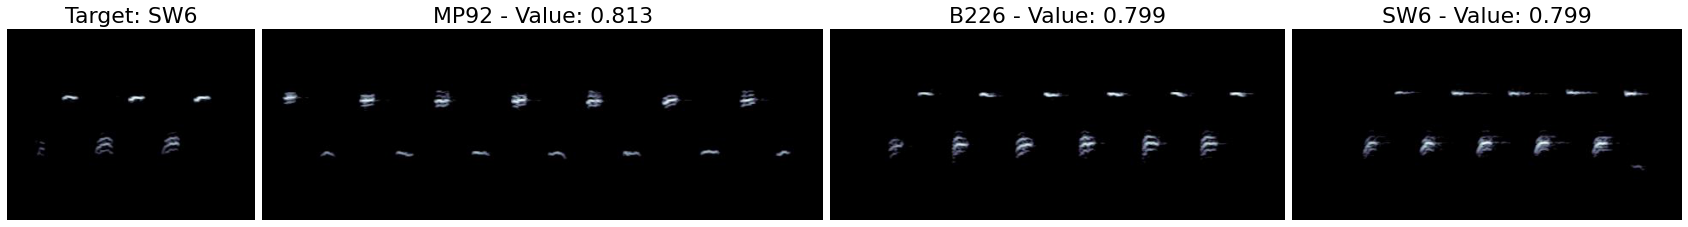

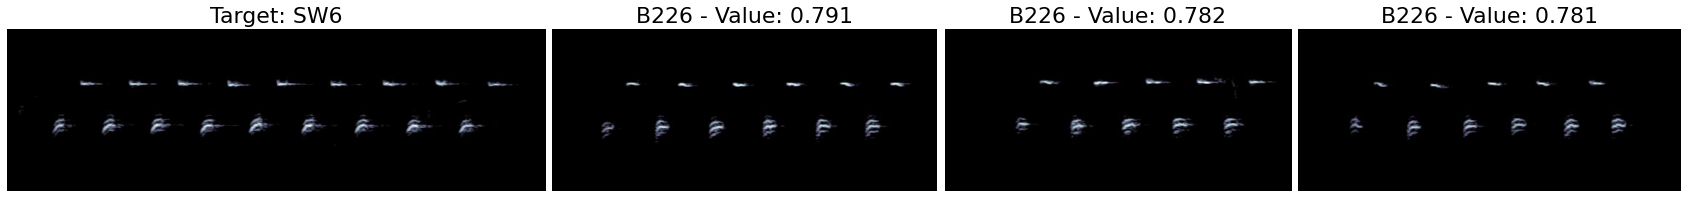

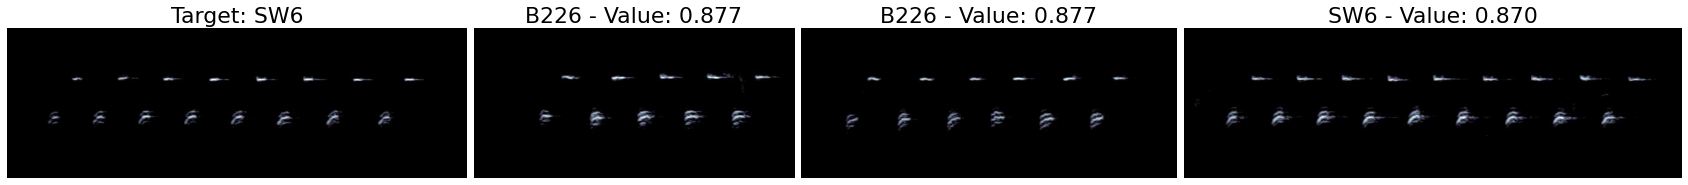

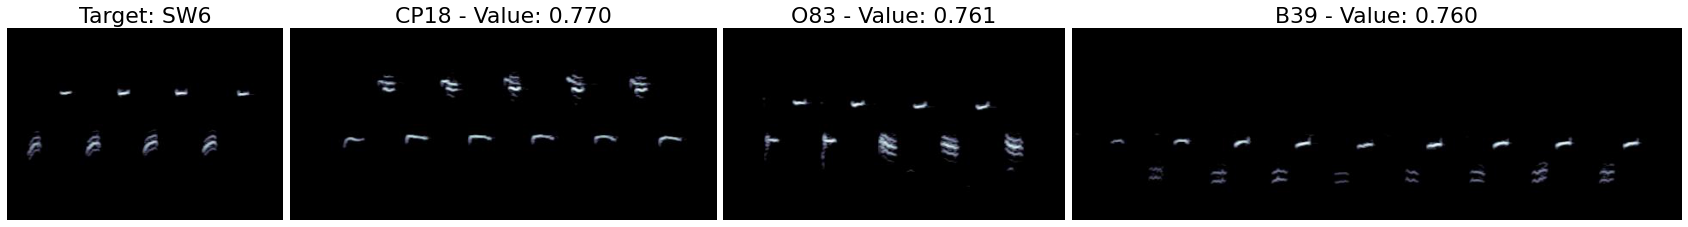

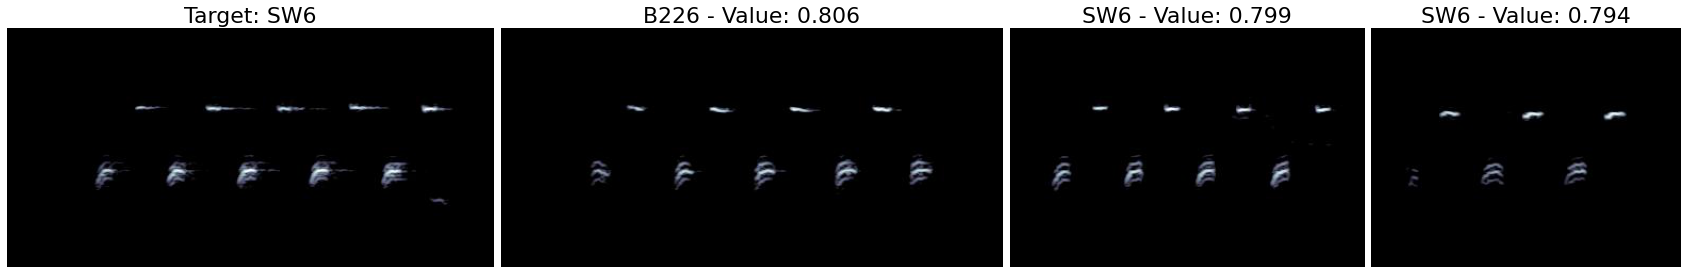

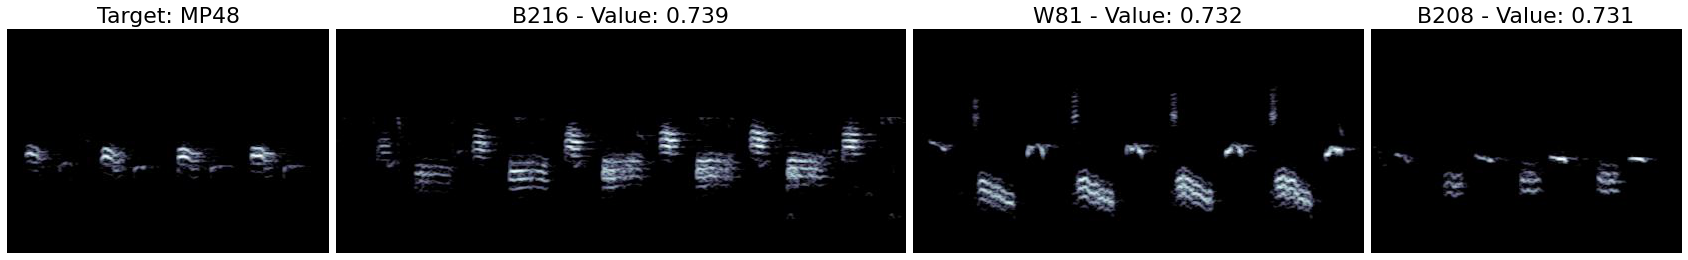

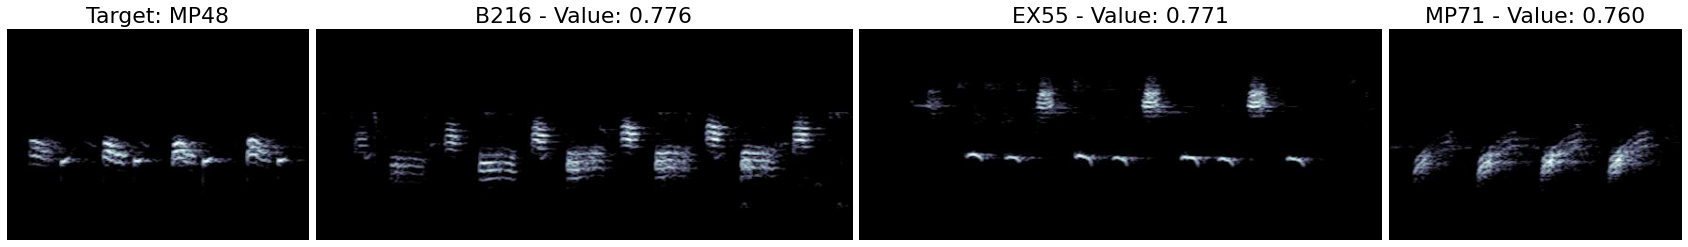

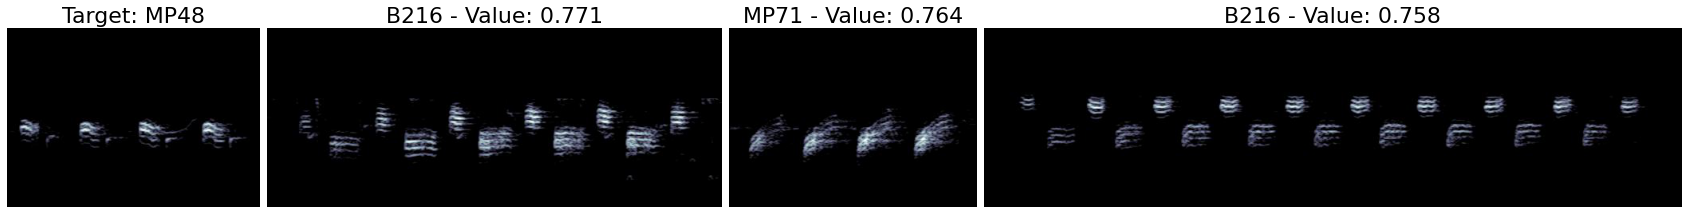

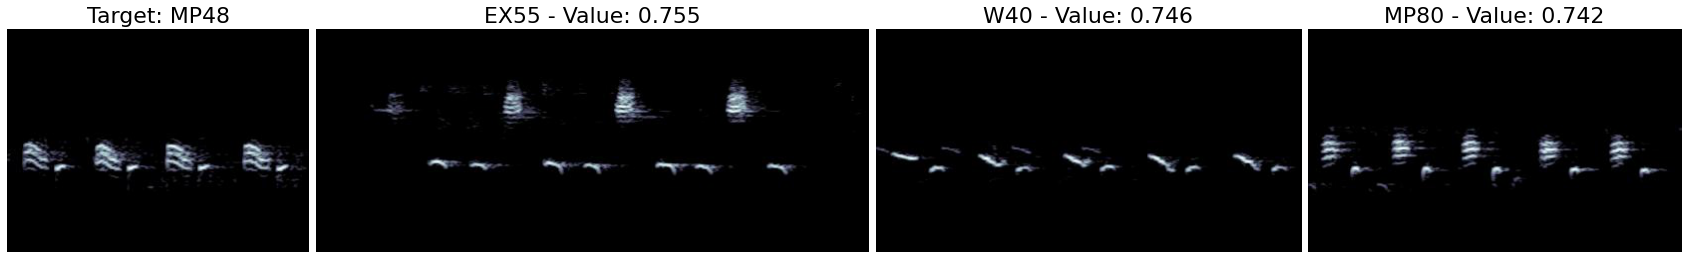

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np


def plot_similar(image):
    imgs, values = getSimilarImages(image, similarNames, similarValues)
    impaths = {image: [img for img in imgpaths if image in str(img)][0]}
    for img in imgs:
        impaths[img] = [p for p in imgpaths if img in str(p)][0]

    fig = plt.figure(figsize=(30, 30))
    grid = ImageGrid(
        fig,
        111,  # similar to subplot(111)
        nrows_ncols=(1, 4),  # creates 2x2 grid of axes
        axes_pad=0.1,  # pad between axes in inch.
    )

    for i, (ax, (im, path)) in enumerate(zip(grid, impaths.items())):
        # Iterating over the grid returns the Axes.
        name = im.split("_")[0]
        if i == 0:
            ax.set_title(f"Target: {name}", fontsize=22)
        else:
            ax.set_title(f"{name} - Value: {values[i]:.3f}", fontsize=22)
        ax.imshow(Image.open(path))
        ax.axis("off")

    plt.show()


for image in similarNames.index[3300:3350]:
    plot_similar(image)


## Measure acoustic spacbe

In [35]:
from sklearn.manifold import MDS
from sklearn.manifold import TSNE


In [ ]:
# Test MDS

mds = MDS(
    metric=True,
    dissimilarity="precomputed",
    random_state=0,
    n_jobs=-1,
    verbose=2,
)
# Get the embeddings
pts = mds.fit_transform(1 - (similarityMatrix.to_numpy() + 0.0000001))


# Get labels
fnames = similarityMatrix.index.values
labels = []
for fname in fnames:
    for p in imgpaths:
        if fname == p.stem:
            labels.append(p.parent.name)

pd.DataFrame(pts, labels)

idx = 0

for idx in range(0, 5):
    labs = [lab if lab == list(set(labels))[idx] else "kk" for lab in labels]
    # Plot the embedding, colored according to the class of the points
    fig = plt.figure(figsize=(8, 8))
    print(list(set(labels))[idx])
    ax = sns.scatterplot(x=pts[:, 0], y=pts[:, 1], hue=labs, legend=False)

# TSNE
mx = 1 - similarityMatrix.to_numpy()
mx = np.round((mx - np.min(mx)) / np.ptp(mx), 5)
tsne = TSNE(n_components=2, metric="precomputed")
tsne_embedding = tsne.fit_transform(mx)

for idx in range(0, 5):
    labs = [lab if lab == list(set(labels))[idx] else "kk" for lab in labels]
    # Plot the embedding, colored according to the class of the points
    fig = plt.figure(figsize=(8, 8))
    print(list(set(labels))[idx])
    ax = sns.scatterplot(
        x=tsne_embedding[:, 0], y=tsne_embedding[:, 1], hue=labs, legend=False
    )

# Use nearest neighbours statistics

#!pip install pynndescent
from pynndescent import NNDescent

index = NNDescent(mx)
knns = index.query(mx[4:5], k=15)
labels[4]

for i, dist in zip(knns[0][0], knns[1][0]):
    print(i)
    print(dist)
    print(f"label: {labels[i]}, dist: {dist}")


# Get median distance to K k nearest neighbours as measure of distinctiveness?
# then convex hull as measure of repertoire diversity, etc


pd.DataFrame(similarityMatrix.to_numpy(), columns=labels, index=labels)

pd.DataFrame(tsne_embedding, columns=["x", "y"], index=labels).query("y >60")


# Add the second plot
ax = fig.add_subplot(1, 2, 2)
# Plot the points again
plt.scatter(pts[:, 0], pts[:, 1])

# Annotate each point by its corresponding face image
for x, ind in zip(X, range(pts.shape[0])):
    im = x.reshape(64, 64)
    imagebox = OffsetImage(im, zoom=0.3, cmap=plt.cm.gray)
    i = pts[ind, 0]
    j = pts[ind, 1]
    ab = AnnotationBbox(imagebox, (i, j), frameon=False)
    ax.add_artist(ab)
plt.title(title)
plt.show()


KeyboardInterrupt: 